In [23]:
import json
import torch
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd


In [24]:
# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaModel.from_pretrained('roberta-base').to(device)

/raid/s3/opengptx/mehdi/git_repos/edu_filter/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Function to embed text using RoBERTa
def embed_text(text, max_length=512):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token representation as the embedding
    return outputs.last_hidden_state[:, 0, :].cpu().squeeze().numpy()

In [27]:
# Read JSONL file and extract text data
def read_jsonl(file_path):
    documents = []
    with open(file_path, 'r') as file:
        for line in file:
            json_obj = json.loads(line)
            if 'text' in json_obj:
                documents.append(json_obj['text'])
    return documents

In [29]:
# Visualize embeddings in 2D plot
def visualize_embeddings(embeddings, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method for dimensionality reduction: choose 'pca' or 'tsne'")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Convert to a DataFrame for easier plotting
    df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(df['Component 1'], df['Component 2'], c='blue', alpha=0.5)
    plt.title(f'2D Visualization of Text Embeddings ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    # Save the plot as a PNG file
    plt.show()  

In [30]:
def visualize_embedding_changes(embeddings_512, embeddings_256, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method for dimensionality reduction: choose 'pca' or 'tsne'")

    # Reduce both sets of embeddings to 2D
    reduced_embeddings_512 = reducer.fit_transform(embeddings_512)
    reduced_embeddings_256 = reducer.fit_transform(embeddings_256)

    # Convert to DataFrames for easier plotting
    df_512 = pd.DataFrame(reduced_embeddings_512, columns=['Component 1', 'Component 2'])
    df_256 = pd.DataFrame(reduced_embeddings_256, columns=['Component 1', 'Component 2'])

    # Plot original positions with 512 token length
    plt.figure(figsize=(10, 8))
    plt.scatter(df_512['Component 1'], df_512['Component 2'], c='blue', label='512 tokens', alpha=0.5)

    # Plot new positions with 256 token length
    plt.scatter(df_256['Component 1'], df_256['Component 2'], c='red', label='256 tokens', alpha=0.5)

    # Draw arrows from the old position to the new position
    for i in range(len(df_512)):
        plt.arrow(df_512['Component 1'][i], df_512['Component 2'][i], 
                  df_256['Component 1'][i] - df_512['Component 1'][i], 
                  df_256['Component 2'][i] - df_512['Component 2'][i], 
                  head_width=0.05, head_length=0.1, fc='green', ec='green')

    plt.title(f'Embedding Position Changes from 512 to 256 Tokens ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

Loaded 1000 documents from /raid/s3/opengptx/mehdi/git_repos/edu_filter/notebooks/../data/1000_documents.json


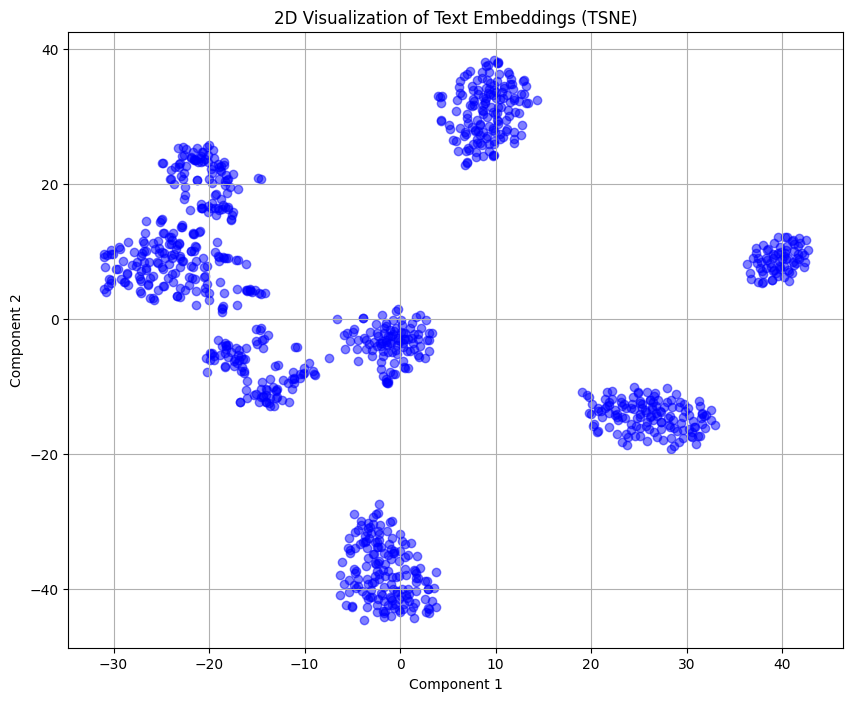

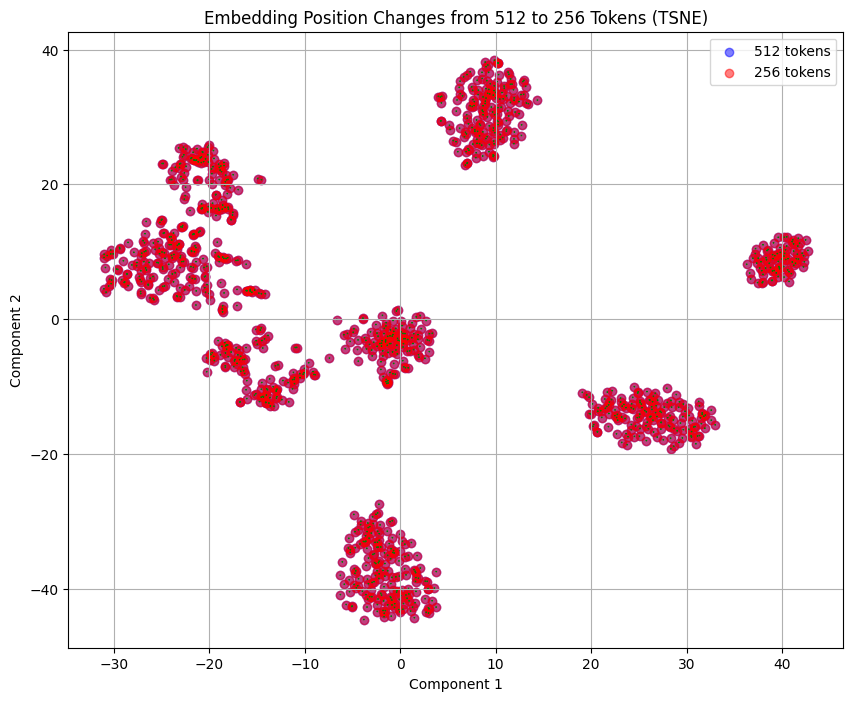

In [33]:
import os
HERE = os.getcwd()
# Path to the JSONL file
jsonl_file = os.path.join(HERE,os.pardir,"data","1000_documents.json")  

# Step 1: Read the JSONL file
documents = read_jsonl(jsonl_file)
print(f"Loaded {len(documents)} documents from {jsonl_file}")

# Step 2: Embed each document's text
embeddings_512 = []
embeddings_256 = []
for max_length, embeddings in zip([512, 256], [embeddings_512, embeddings_256]):
    for text in documents:
        embeddings.append(embed_text(text))
    
# Convert list to tensor
embeddings_256 = torch.tensor(embeddings_256)  
embeddings_512 = torch.tensor(embeddings_512) 


# Step 3: Visualize the embeddings in 2D
visualize_embeddings(embeddings_512, method='tsne')  # Choose either 'pca' or 'tsne'

# Step 4: Visualize the change in embedding positions
visualize_embedding_changes(embeddings_512, embeddings_256, method='tsne')
